1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

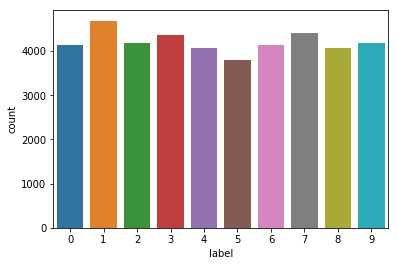

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()


In [3]:
X_train.isnull().any().describe()
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [4]:
X_train = X_train / 255.0
test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

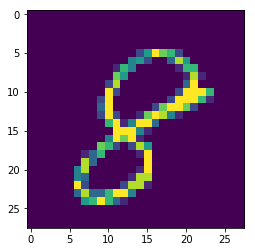

In [5]:
g = plt.imshow(X_train[0][:,:,0])

In [6]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [7]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [9]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

train_generator = datagen.flow(X_train,Y_train, batch_size=batch_size)

In [10]:
history = model.fit_generator(train_generator,
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
439/439 [==============================] - 14s 32ms/step - loss: 0.4084 - acc: 0.8691 - val_loss: 0.0777 - val_acc: 0.9769
Epoch 2/30
439/439 [==============================] - 10s 22ms/step - loss: 0.1285 - acc: 0.9618 - val_loss: 0.0451 - val_acc: 0.9855
Epoch 3/30
439/439 [==============================] - 10s 22ms/step - loss: 0.0957 - acc: 0.9708 - val_loss: 0.0350 - val_acc: 0.9898
Epoch 4/30
439/439 [==============================] - 10s 23ms/step - loss: 0.0777 - acc: 0.9768 - val_loss: 0.0307 - val_acc: 0.9914
Epoch 5/30
439/439 [==============================] - 10s 22ms/step - loss: 0.0714 - acc: 0.9797 - val_loss: 0.0288 - val_acc: 0.9912
Epoch 6/30
439/439 [==============================] - 10s 23ms/step - loss: 0.0699 - acc: 0.9792 - val_loss: 0.0250 - val_acc: 0.9929
Epoch 7/30
439/439 [==============================] - 10s 22ms/step - loss: 0.0607 - acc: 0.9824 - val_loss: 0.0331 - val_acc: 0.9902
Epoch 8/30
439/439 [==============================] - 10s 23ms

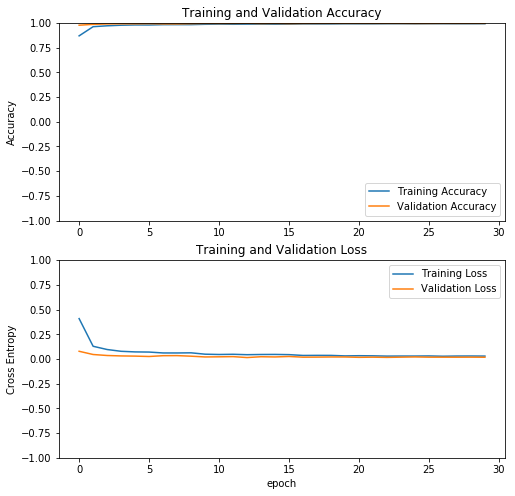

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([-1,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:

res = model.predict(test)
res = np.argmax(res,axis = 1)
res = pd.Series(res, name="Label")
submission = pd.concat([pd.Series(range(1 ,28001) ,name = "ImageId"),   res],axis = 1)
submission.to_csv("cnn_mnist_datagen.csv",index=False)
submission.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
